In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon import RESTClient
import datetime as dt
from pandas.tseries.offsets import BDay
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import PercentFormatter
import stock_data_functions
from matplotlib.dates import MonthLocator, DateFormatter

import requests 
import time
import json
import seaborn as sns
import math
import importlib
import pca_functions
importlib.reload(pca_functions)

client = RESTClient('tt2gOLH0fHAmPX70a4QURLFy59PRCZr3')
API_key = 'tt2gOLH0fHAmPX70a4QURLFy59PRCZr3'


import scipy.stats as stats
from fredapi import Fred
fred_api = Fred('e48d0413b1cd0a3b30b58d42225373de')

In [3]:
importlib.reload(stock_data_functions)
from stock_data_functions import SECTOR_ETFs, THEME_ETFs, STYLE_ETFs, get_rets_cumsum

In [23]:
df_sector = pd.read_csv('sector_ETF_rets.csv', index_col='Date', parse_dates=True)
df_style = pd.read_csv('style_ETF_rets.csv', index_col='Date', parse_dates=True)
df_theme = pd.read_csv('theme_ETF_rets.csv', index_col='Date', parse_dates=True)

rets = pd.concat([df_sector, df_style, df_theme], axis=1)

### PCA on Regressor Rets

In [5]:
from pca_functions import pca_analysis, pc_weights_from_loadings, make_pc_portfolios
from sklearn.model_selection import train_test_split

In [6]:
train_rets, test_rets = train_test_split(rets, test_size=0.2, shuffle=False)
rets_cumsum = get_rets_cumsum(rets)
train_cum, test_cum = train_test_split(rets_cumsum, test_size=0.2, shuffle=False)

In [7]:
train_loadings, train_explained_var_by_PC, train_eigenvalues = pca_analysis(tag = False,
                                                          dfs = train_rets,
                                                          start_date=train_rets.index[0],
                                                          end_date=train_rets.index[-1])

2023-10-03 00:00:00 2025-05-06 00:00:00


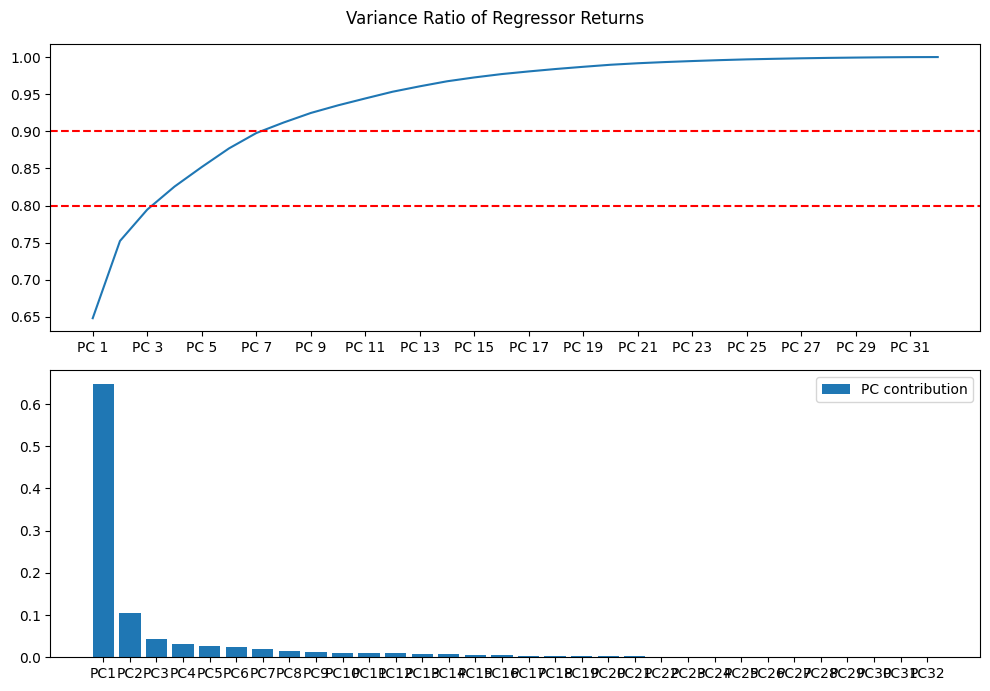

In [8]:
fig, axs = plt.subplots(2, 1, figsize = (10, 7), sharex=False)
axs[0].plot(train_explained_var_by_PC['cumsum'], label = 'Cumulative Variance Ratio Explained')
axs[1].bar(train_explained_var_by_PC.index, train_explained_var_by_PC['PC'], label = 'PC contribution')

axs[0].set_xticks(np.arange(0, len(train_explained_var_by_PC), 2))
axs[0].set_xticklabels([f'PC {i+1}' for i in range(0, len(train_explained_var_by_PC), 2)])
axs[0].axhline(0.8, color='red', ls='--')
axs[0].axhline(0.9, color='red', ls='--')
plt.legend()
plt.suptitle('Variance Ratio of Regressor Returns')
plt.tight_layout()

In [9]:
top_8_pcs_train           = train_loadings.iloc[:,:8]
top_8_weights_train       = pc_weights_from_loadings(top_8_pcs_train)
pc_portfolios_train       = make_pc_portfolios(train_rets, top_8_weights_train)

In [10]:
pc_portfolio_train_cumsum = get_rets_cumsum(pc_portfolios_train)
start_date = pc_portfolio_train_cumsum.index[0] - pd.Timedelta(1, 'day')
end_date   = pc_portfolio_train_cumsum.index[-1]

In [11]:
SPX = fred_api.get_series('SP500', observation_start = start_date , observation_end=end_date).to_frame('SPX')
avaliable_dates = set(rets.index.strftime('%Y-%m-%d'))
SPX = SPX.reindex(avaliable_dates).dropna() 
SPX = SPX.dropna()
SPX.index = pd.to_datetime(SPX.index)
SPX.sort_index(inplace=True)
SPX = SPX / SPX.iloc[0]

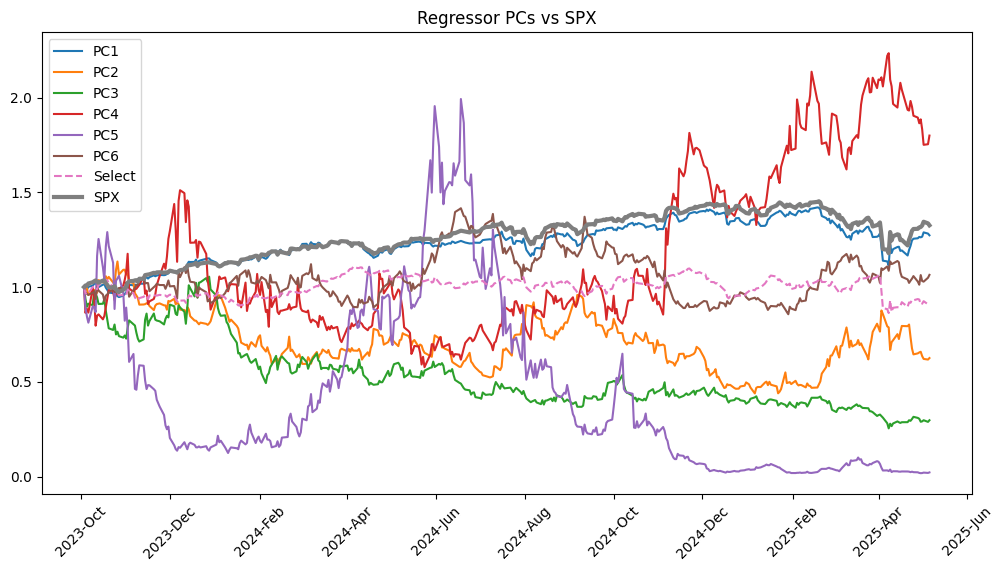

In [13]:
n = 6

plt.figure(figsize=(12,6))

for i in pc_portfolio_train_cumsum.columns[:n]:
    plt.plot(pc_portfolio_train_cumsum[i], label = f'{i}')

plt.plot(train_cum['Energy Select Sector SPDR'], ls = '--', label='Select')
plt.plot(SPX, label = 'SPX', lw = 3)
plt.title('Regressor PCs vs SPX')

plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.tick_params(axis = 'x',
                rotation = 45)

plt.legend()

In [15]:
n = 3
top_tickers_per_pc_train = pca_functions.top_stocks_per_pc(train_loadings, n =12, top=50)
top_tickers_per_pc_train.loc[f'PC{n}'].sort_values(ascending=False, by='Value')

,Value
Ticker,
Solar / Clean Energy ETF,0.599986
Lithium & Battery Tech ETF,0.538765
Data Center / Digital Infrastructure ETF,0.240871
ARK Innovation ETF,0.182671
Real Estate Select Sector SPDR,0.145391
ARK Next Gen Internet ETF,0.120856
Invesco DWA SmallCap Momentum ETF,0.093042
Global Robotics & AI ETF,0.079351
Utilities Select Sector SPDR,0.075934


1st PC is market
2nd PC is defensive vs risk-on
3rd PC is “Clean Energy / Transition / Battery + Electrification” - Semis/defensive/tech
4th PC is Digital Infrastructure + Backbone Exposure
5th PC is “Cyclical / Value / Industrial-Heavy vs. Growth / Tech Innovation -> energy/cyclical growth retrenchment
6th PC is Quality/Defensive Tech Infrastructure vs. Cyclical & Speculative Risk
7th PC is Defensive Income / Utilities & Real Assets Factor”

In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

r2_train   = {}
coef_train = {}

In [21]:
semi_stock_rets = pd.read_csv('semi_stocks_time_series.csv', header=[2], index_col=[1], parse_dates=True)

/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_19986/1413229816.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  semi_stock_rets = pd.read_csv('semi_stocks_time_series.csv', header=[2], index_col=[1], parse_dates=True)


In [22]:
semi_stock_rets

,Date,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 579,Unnamed: 580,Unnamed: 581,Unnamed: 582,Unnamed: 583,Unnamed: 584,Unnamed: 585,Unnamed: 586,Unnamed: 587,Unnamed: 588
-0.024078,2023-10-04,-0.805725,Normal,-0.022113,-0.624024,Normal,0.001063,-0.061521,Normal,0.011969,...,Normal,0.006079,0.217953,Normal,0.002223,0.079820,Normal,0.004088,0.228970,Normal
0.007017,2023-10-05,0.125068,Normal,0.017003,0.353602,Normal,0.013673,0.361971,Normal,0.014584,...,Moderate Negative,-0.025474,-1.108861,Moderate Negative,-0.031848,-1.482680,Moderate Negative,0.003448,0.188999,Normal
0.003241,2023-10-06,0.012049,Normal,0.019606,0.418650,Normal,0.003139,0.008210,Normal,0.023749,...,Moderate Positive,0.032309,1.320930,Moderate Positive,0.040465,1.833637,Moderate Positive,-0.004324,-0.296310,Normal
0.014579,2023-10-09,0.351436,Normal,-0.004027,-0.171996,Normal,0.007738,0.162652,Normal,-0.010743,...,Normal,0.000482,-0.017386,Normal,0.020039,0.896874,Normal,-0.014424,-0.927003,Normal
0.010383,2023-10-10,0.225825,Normal,0.014239,0.284503,Normal,0.016098,0.443398,Normal,0.011530,...,Normal,0.016869,0.671686,Normal,-0.000363,-0.038749,Normal,0.007035,0.412969,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-0.029868,2025-09-25,-0.979050,Normal,0.002666,-0.004721,Normal,-0.013055,-0.535670,Normal,0.004060,...,Normal,-0.021993,-0.962512,Normal,-0.009800,-0.471555,Normal,-0.012393,-0.800161,Normal
0.020928,2025-09-26,0.541496,Normal,-0.002722,-0.139392,Normal,0.010372,0.251108,Normal,0.002810,...,Moderate Positive,0.023452,0.948514,Normal,0.041985,1.903350,Moderate Positive,0.001533,0.069401,Normal
0.012577,2025-09-29,0.291515,Normal,0.023258,0.509909,Normal,0.030347,0.921952,Normal,0.020332,...,Moderate Negative,-0.016960,-0.750833,Normal,-0.057140,-2.642613,Large Negative,0.008849,0.526242,Normal
0.009131,2025-09-30,0.188360,Normal,0.018043,0.379578,Normal,0.006412,0.118129,Normal,0.025678,...,Normal,-0.002231,-0.131483,Normal,0.005316,0.221666,Normal,0.004370,0.246603,Normal


In [18]:
r2_train_tech   = {}
coef_train_tech = {}

In [19]:
r2_train_port   = {}
coef_train_port = {}

In [ ]:
  # or fdrcorrection

ticker = 'GE'
MU = TickerData(ticker, filing_date_gte='2023-10-01')
MU.get_historical_prices()

try:
    MU.get_ratios()
    MU.calc_zscore_and_rets()
    y_rets = MU.summary_returns_data['close'].loc[:end_date]
except:
    y_rets =  MU.historical_prices.apply(calc_log_rets)['close'].loc[:end_date]


# X are your PC portfolios, y is y_rets
X = sm.add_constant(pc_portfolios_train)        
#X = X.reindex(y_rets.index)
ols = sm.OLS(y_rets, X).fit(
    cov_type="HAC", 
    cov_kwds={"kernel": "bartlett", "maxlags": 5},  # tune maxlags to your freq
    use_t=True
)

# FDR (Benjamini–Hochberg) over all coefficients including the intercept (drop it if you prefer)
rej, qvals, _, _ = multipletests(ols.pvalues, alpha=0.05, method="fdr_bh")

# Keep only coefficients that pass FDR (you can force the constant to stay)
keep = (rej & (X.columns != "const")) | (X.columns == "const")
X_sel = X.loc[:, keep]

# Refit on the reduced set with HAC SEs
ols_sel = sm.OLS(y_rets, X_sel).fit(
    cov_type="HAC", cov_kwds={"kernel": "bartlett", "maxlags": 5}, use_t=True
)

print(ols_sel.summary())

coef_train_port[ticker]  = pd.concat([ols_sel.params,ols_sel.pvalues], axis = 1, keys=['Coefficient', 'p-val'])
r2_train_port[ticker] = ols_sel.rsquared_adj

predicted = ols_sel.predict(X_sel)
residuals = y_rets - predicted
sns.scatterplot(x=predicted, y=residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.grid()

In [1186]:
name_summary_df = pd.concat(name_summary, axis=1)
summary['AMD']

,TopCorr AMD,LeastCorr AMD,AvgCorr AMD
ALAB,NaN,0.381439,0.56038
AMD,1.000000,NaN,0.56038
ARM,NaN,0.478610,0.56038
CRDO,NaN,0.489065,0.56038
ENTG,0.613476,NaN,0.56038
INTC,NaN,0.364681,0.56038
KLAC,0.652045,NaN,0.56038
LRCX,0.652071,NaN,0.56038
NVDA,0.618668,NaN,0.56038
RMBS,0.617407,NaN,0.56038


Call ENTG.calc_zscore_and_rets() to get returns data
Request URL: https://api.polygon.io/v2/aggs/ticker/ENTG/range/1/day/2023-10-01/2025-10-01?limit=5000
Request Headers: {'Authorization': 'Bearer REDACTED', 'Accept-Encoding': 'gzip', 'User-Agent': 'Polygon.io PythonClient/1.15.3'}
Response Headers: {'Date': 'Thu, 02 Oct 2025 01:38:43 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': '5c363df8b3a02bbbb68093bd3f51b295', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}


/Users/phillip/Desktop/Moon2/stock_data_functions.py:617: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative TTM P/E'] = np.where(df['TTM P/E'] < 1, df['TTM P/E'], np.nan)
/Users/phillip/Desktop/Moon2/stock_data_functions.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative Q P/E'] = np.where(df['quarterly P/E diluted'] < 1, df['quarterly P/E diluted'], np.nan)


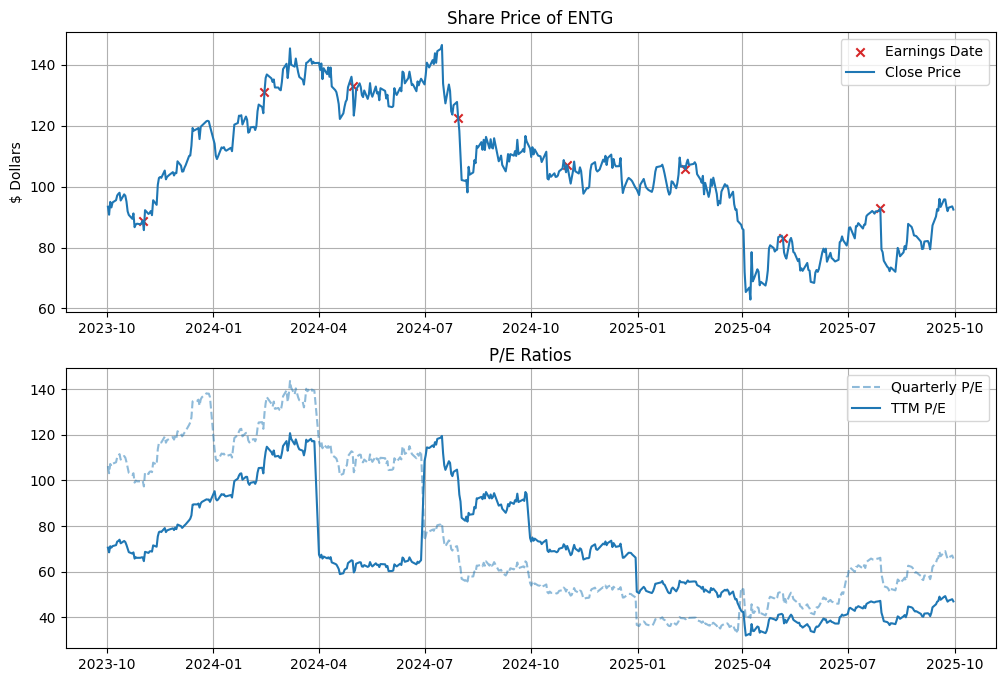

In [1191]:
ENTG = TickerData('ENTG', filing_date_gte='2023-10-01')
ENTG.get_historical_prices()
ENTG.get_ratios()
ENTG.plot_single_timeseries()

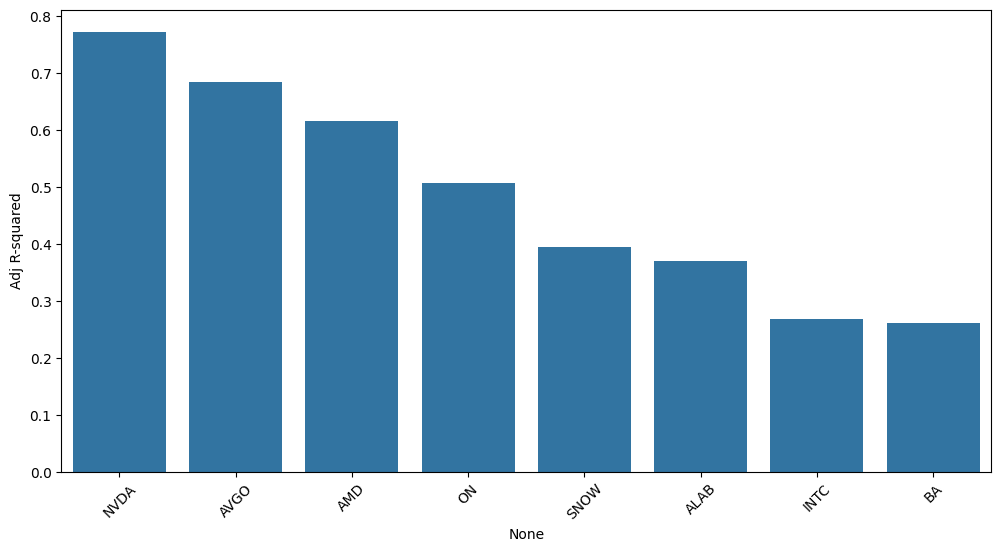

In [ ]:
r2 = pd.DataFrame(r2_train_port.values(), r2_train_port.keys(), columns=['Adj R-squared'])
r2.sort_values(ascending=False, by='Adj R-squared', inplace=True)
plt.figure(figsize = (12,6))
sns.barplot(data=r2, x=r2.index, y='Adj R-squared')
plt.gca().tick_params(axis = 'x', rotation = 45)


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from stock_data_functions import PC_Definitions

def plot_pcs_two_cols(
    pc_dict: dict,
    *,
    sort: str = "abs",               # "abs" | "value" | "ticker"
    const_fmt: str = "{:.2f}",       # constant label format
    per_subplot_width: float = 6.5,  # width per subplot (make figure longer)
    per_row_height: float = 3.0,     # height per row of two subplots
    pc_definitions: dict | None = None,   # {"PC1": "Market", "PC2": "...", ...}
    pc_title_fmt: str = "{pc} — {label}"  # how to display title when a label exists
):
    """
    pc_dict: {ticker -> DataFrame(index=['const','PC1','PC2',...],
                                  columns=['Coefficient','p-val' (optional)])}
    Produces a single figure with 2 subplots per row, wide layout, shared y-scale,
    consistent colors per ticker, and constants shown above bars.

    pc_definitions: optional dict mapping PC names to human-readable labels.
                    Keys should match row names like "PC1","PC2",...
    pc_title_fmt:   format for subplot titles when a label exists.
                    Available fields: {pc} (e.g., "PC2"), {label} (mapped string).
    """

    # --- Collect coefficients & constants
    coef_series = {}
    const_vals = {}
    for ticker, df in pc_dict.items():
        if df is None or df.empty():
            continue
        di = df.copy()
        di.index = di.index.astype(str).str.strip()
        if "Coefficient" not in di.columns:
            continue
        coef_series[ticker] = di["Coefficient"]
        const_idx = next((r for r in di.index if r.lower() == "const"), None)
        if const_idx is not None:
            const_vals[ticker] = float(pd.to_numeric(di.loc[const_idx, "Coefficient"], errors="coerce"))

    if not coef_series:
        raise ValueError("No coefficient data found in pc_dict.")

    # Wide matrix: rows = factors (PCs/const), cols = tickers
    coef_mat = pd.concat(coef_series, axis=1)
    coef_mat.columns.name = "Ticker"

    # Identify PC rows and sort numerically (PC1, PC2, ...)
    pc_rows = [r for r in coef_mat.index if r.upper().startswith("PC")]
    if not pc_rows:
        raise ValueError("No rows starting with 'PC' found.")

    def pc_num(name: str) -> int:
        digits = "".join(ch for ch in name if ch.isdigit())
        return int(digits) if digits else 10**9

    pc_rows = sorted(pc_rows, key=pc_num)

    # Consistent colors per ticker
    all_tickers = sorted(coef_mat.columns)
    def make_color_map(names):
        n = len(names)
        if n <= 20:
            cmap = cm.get_cmap("tab20", n)
        else:
            cmap = cm.get_cmap("hsv", n)
        return {name: cmap(i) for i, name in enumerate(names)}
    color_of = make_color_map(all_tickers)

    # Shared y-scale across all PCs
    global_min, global_max = np.inf, -np.inf
    for pc in pc_rows:
        s = coef_mat.loc[pc].dropna()
        if s.empty:
            continue
        global_min = min(global_min, s.min())
        global_max = max(global_max, s.max())
    if not np.isfinite(global_min) or not np.isfinite(global_max):
        global_min, global_max = -1.0, 1.0
    y_range = global_max - global_min if global_max != global_min else 1.0
    pad = 0.05 * y_range
    y_min, y_max = global_min - pad, global_max + pad

    # --- Layout: always 2 columns per row (wide figure)
    ncols = 2
    n_pcs = len(pc_rows)
    nrows = math.ceil(n_pcs / ncols)

    fig_w = per_subplot_width * ncols   # long lengthways
    fig_h = per_row_height * nrows      # modest height growth
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), sharey=True)
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # Plot each PC
    for ax, pc in zip(axes, pc_rows):
        s = coef_mat.loc[pc].dropna()
        if s.empty:
            ax.set_visible(False)
            continue

        if sort == "abs":
            s = s.reindex(s.abs().sort_values(ascending=False).index)
        elif sort == "value":
            s = s.sort_values(ascending=False)
        else:
            s = s.sort_index()

        colors = [color_of[t] for t in s.index]
        bars = ax.bar(s.index, s.values, color=colors)

        # Title with definition if available
        if pc_definitions and pc in pc_definitions and pc_definitions[pc]:
            title = pc_title_fmt.format(pc=pc, label=pc_definitions[pc])
        else:
            title = pc
        ax.set_title(title, wrap=True)

        ax.axhline(0, lw=1, color="gray")
        ax.set_ylim(y_min, y_max)
        ax.tick_params(axis="x", labelrotation=60)
        ax.grid(axis="y", linestyle=":", alpha=0.4)
        ax.margins(x=0.005)

        # constants above bars
        for bar, ticker in zip(bars, s.index):
            alpha = const_vals.get(ticker, np.nan)
            if not np.isnan(alpha):
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                ax.text(x, y + 0.02*y_range, const_fmt.format(alpha),
                        ha="center", va="bottom", fontsize=8)

    # Hide any unused axes
    for j in range(len(pc_rows), len(axes)):
        axes[j].set_visible(False)

    # Legend at bottom center (wide figure)
    legend_handles = [Patch(facecolor=color_of[t], label=t) for t in all_tickers]
    fig.legend(handles=legend_handles, loc="lower center",
               ncol=min(len(all_tickers), 10), bbox_to_anchor=(0.5, 0.0), frameon=False)

    fig.suptitle("PC Coefficients by Ticker (shared scale, consistent colors)", y=0.995, fontsize=12)
    fig.tight_layout(rect=[0.02, 0.06, 0.985, 0.96])
    plt.show()


/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_26657/3892337143.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", n)


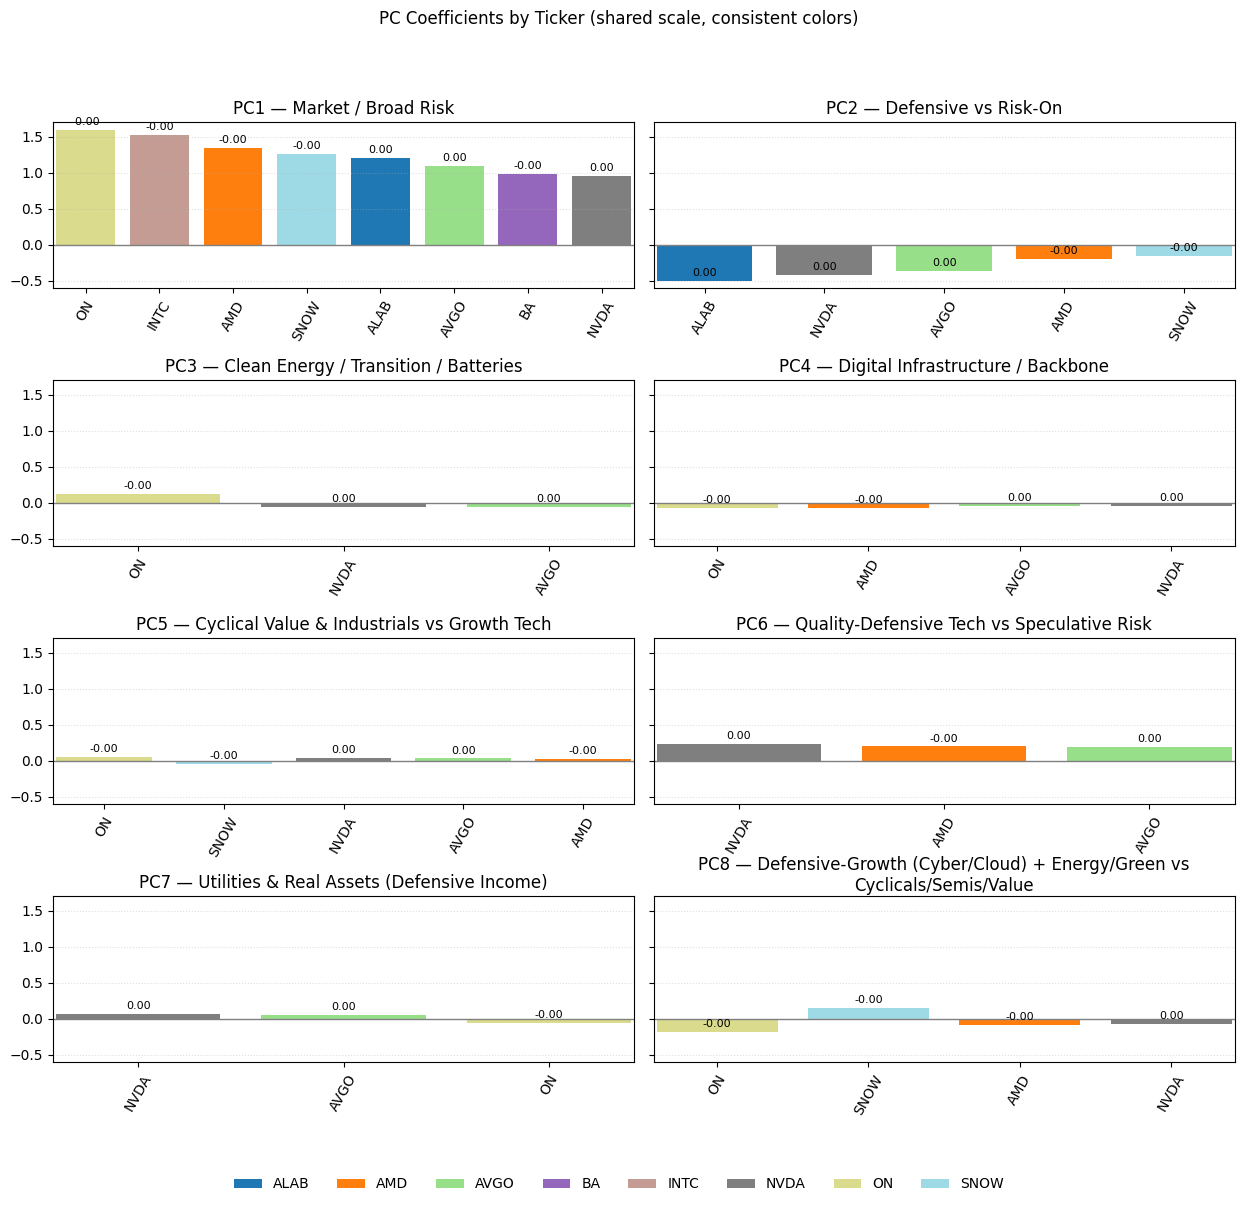

In [ ]:
plot_pcs_two_cols(
    coef_train_port,
    sort="abs",
    const_fmt="{:.2f}",
    per_subplot_width=6.5,
    per_row_height=3.0,
    pc_definitions=PC_Definitions,
    pc_title_fmt="{pc} — {label}"
)

/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_26657/3892337143.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", n)


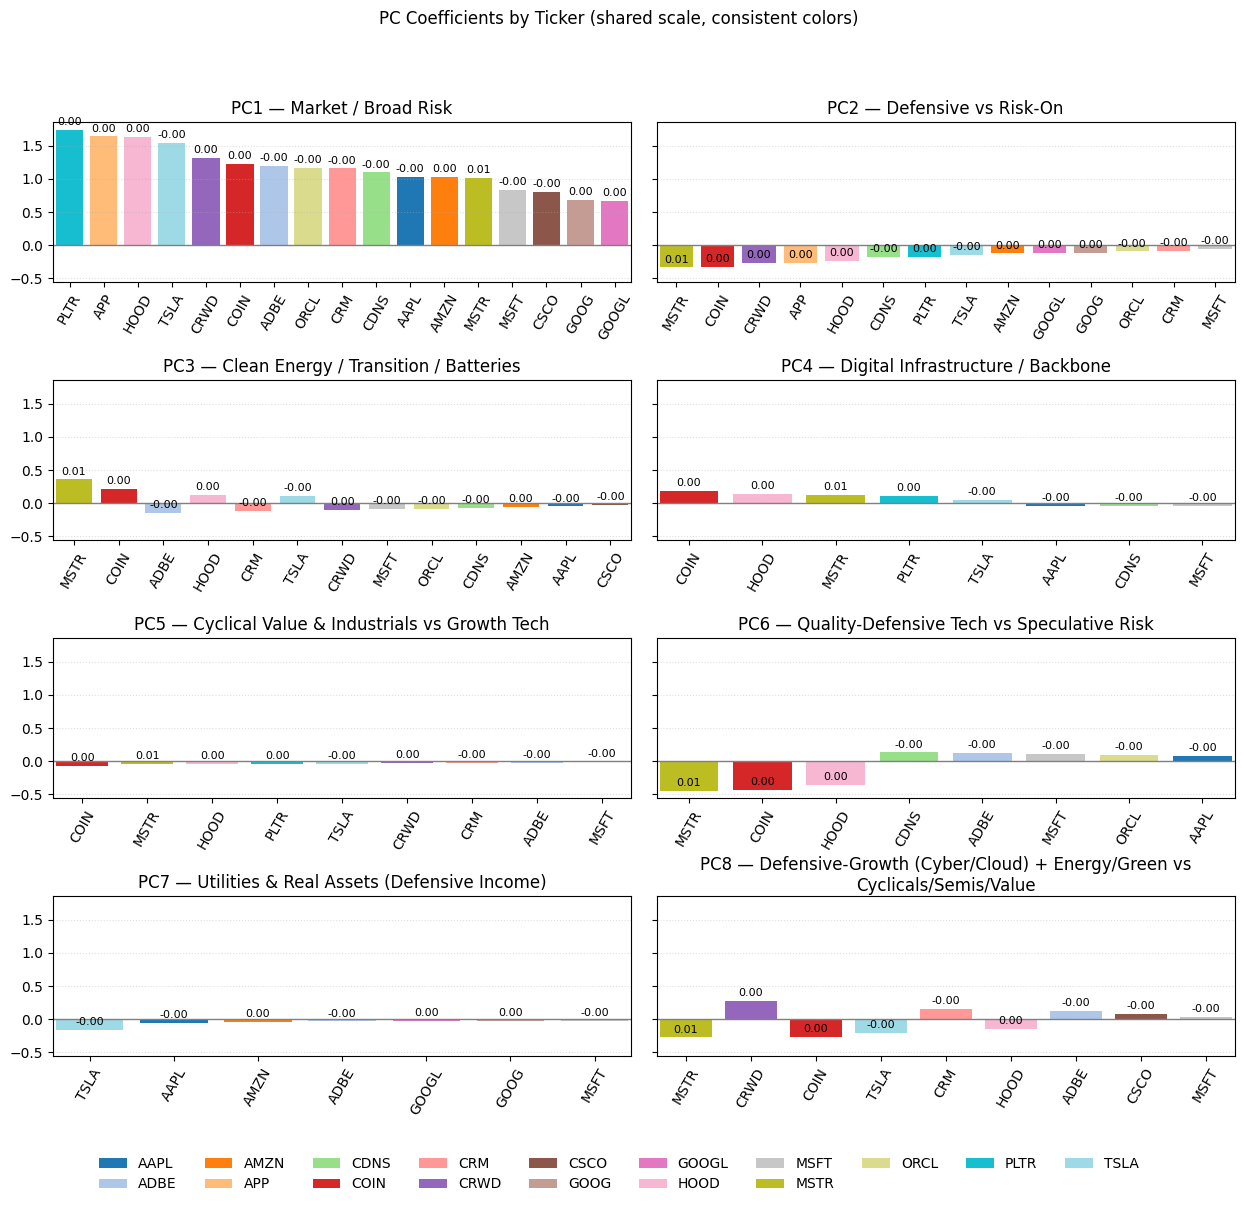

In [ ]:
plot_pcs_two_cols(
    coef_train_tech,
    sort="abs",
    const_fmt="{:.2f}",
    per_subplot_width=6.5,
    per_row_height=3.0,
    pc_definitions=PC_Definitions,
    pc_title_fmt="{pc} — {label}"
)

Call ADSK.calc_zscore_and_rets() to get returns data
Request URL: https://api.polygon.io/v2/aggs/ticker/ADSK/range/1/day/2023-10-01/2025-10-01?limit=5000
Request Headers: {'Authorization': 'Bearer REDACTED', 'Accept-Encoding': 'gzip', 'User-Agent': 'Polygon.io PythonClient/1.15.3'}
Response Headers: {'Date': 'Thu, 02 Oct 2025 10:11:39 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': 'c479c7ac2f2c294cbc8b2d0b679cfe25', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}


/Users/phillip/Desktop/Moon2/stock_data_functions.py:617: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative TTM P/E'] = np.where(df['TTM P/E'] < 1, df['TTM P/E'], np.nan)
/Users/phillip/Desktop/Moon2/stock_data_functions.py:618: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative Q P/E'] = np.where(df['quarterly P/E diluted'] < 1, df['quarterly P/E diluted'], np.nan)


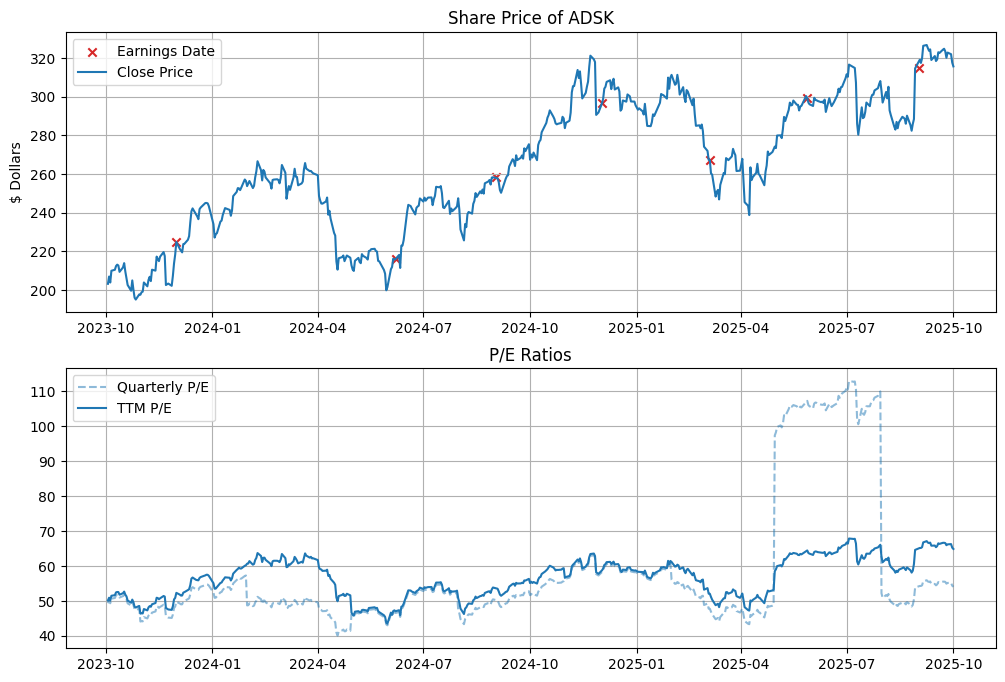

In [1198]:
brk = TickerData('ADSK', filing_date_gte='2023-10-01')
brk.get_historical_prices()
brk.get_ratios()
brk.plot_single_timeseries()

Call CDNS.calc_zscore_and_rets() to get returns data
Request URL: https://api.polygon.io/v2/aggs/ticker/CDNS/range/1/day/2023-10-03/2025-09-30?limit=5000
Request Headers: {'Authorization': 'Bearer REDACTED', 'Accept-Encoding': 'gzip', 'User-Agent': 'Polygon.io PythonClient/1.15.3'}
Response Headers: {'Date': 'Wed, 01 Oct 2025 10:34:32 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': '26038259da81e0f0c4ae98d504287614', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}


/Users/phillip/Desktop/Moon2/stock_data_functions.py:620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative TTM P/E'] = np.where(df['TTM P/E'] < 1, df['TTM P/E'], np.nan)
/Users/phillip/Desktop/Moon2/stock_data_functions.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative Q P/E'] = np.where(df['quarterly P/E diluted'] < 1, df['quarterly P/E diluted'], np.nan)


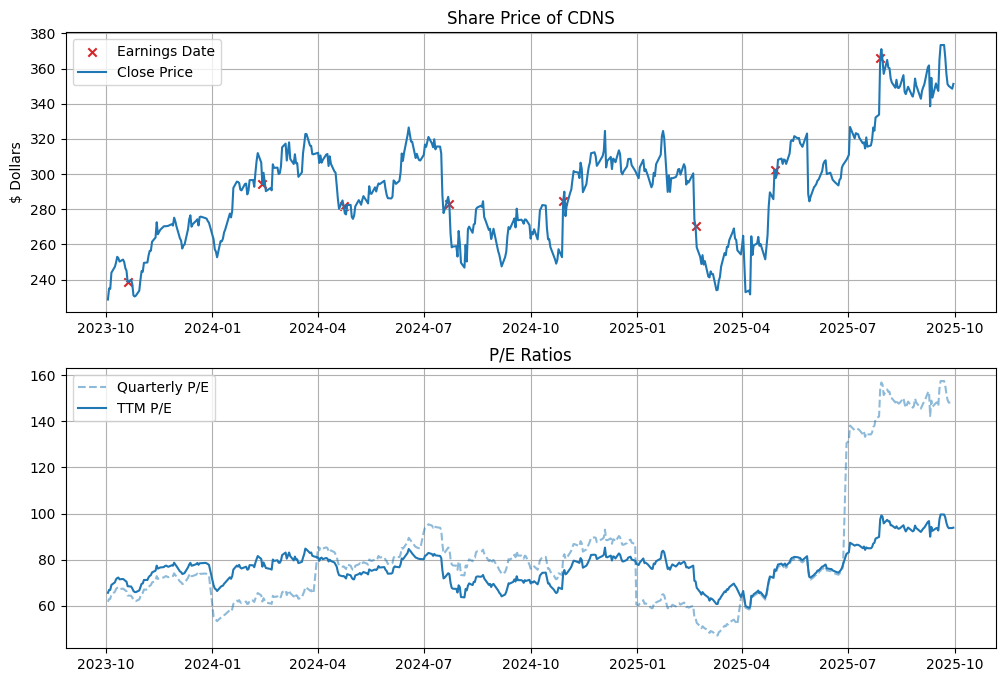

In [ ]:
Stock = TickerData('CDNS', filing_date_gte='2023-10-03')
Stock.get_historical_prices()
Stock.plot_single_timeseries()

set return_data to True to get the dataset


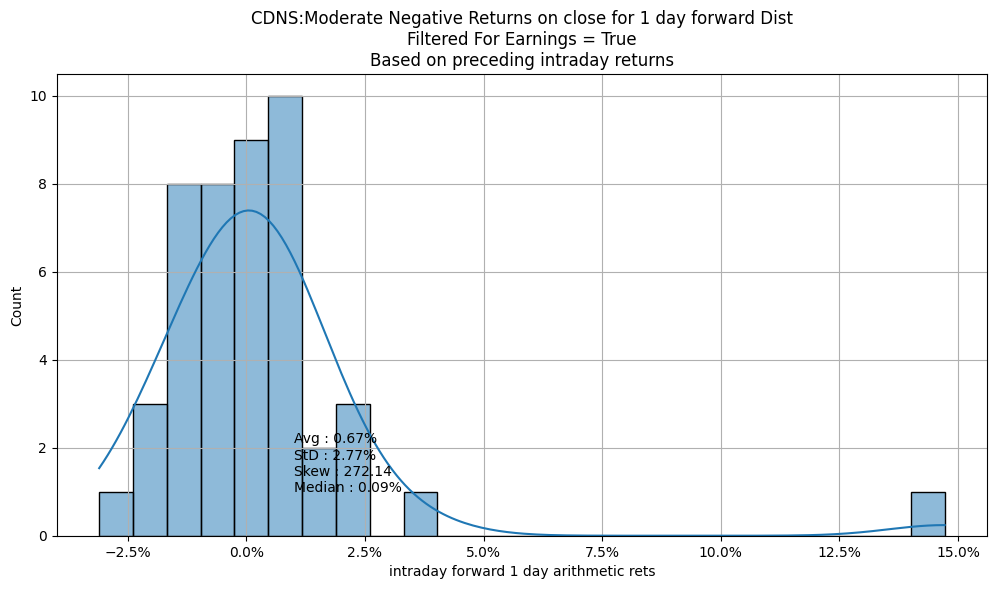

In [ ]:
Stock.plot_fwd_returns_distribution_by_return_z(bucket_class='Moderate Negative', rets_type='intraday', fwd_rets_type='close', window=1)

/var/folders/2_/q3fhp8js4zgd2w2m2cb4y8rh0000gn/T/ipykernel_26657/3892337143.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("hsv", n)


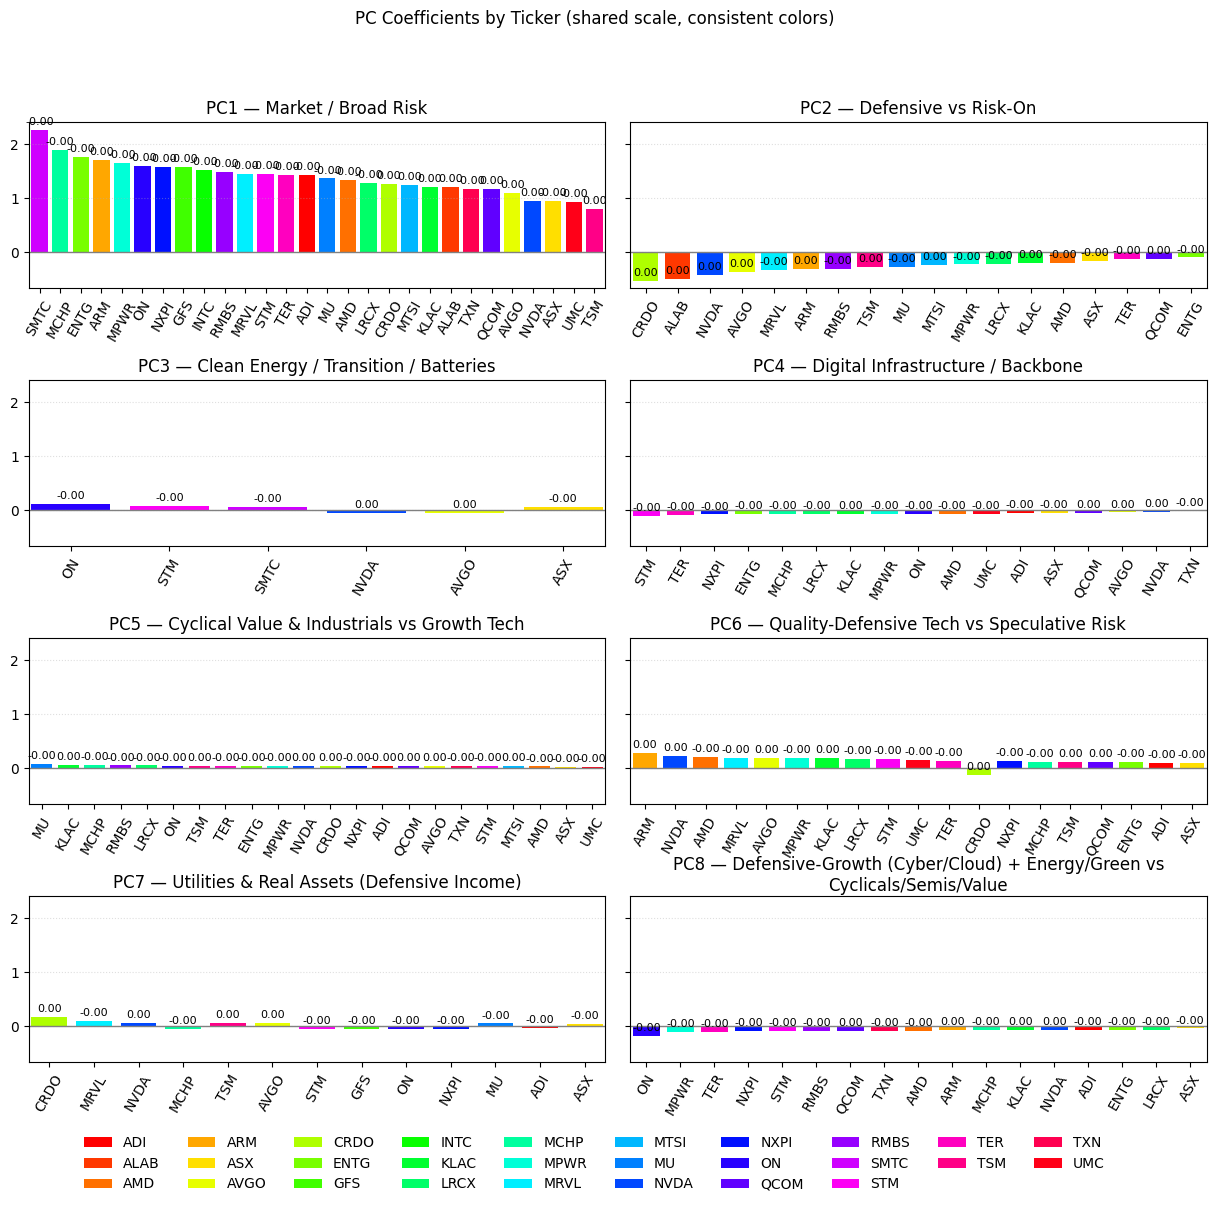

In [ ]:
plot_pcs_two_cols(
    coef_train,
    sort="abs",
    const_fmt="{:.2f}",
    per_subplot_width=6.5,
    per_row_height=3.0,
    pc_definitions=PC_Definitions,
    pc_title_fmt="{pc} — {label}"
)

In [ ]:
from itertools import combinations
from numpy.linalg import norm

def build_beta_matrix(pc_dict):
    # DataFrame: rows=tickers, cols=PCs (missing → 0)
    series = {}
    for t, df in pc_dict.items():
        if df is None or df.empty: 
            continue
        s = df["Coefficient"].copy()
        s.index = s.index.astype(str)
        s = s[s.index.str.upper().str.startswith("PC")]
        series[t] = s
    M = pd.DataFrame(series).T.fillna(0.0)   # tickers × PCs
    # sort columns PC1..PCk
    M = M.reindex(sorted(M.columns, key=lambda x: int(''.join(ch for ch in x if ch.isdigit()))), axis=1)
    return M

def top_pairs_by_cosine(M: pd.DataFrame, top_k=10):
    pairs = []
    for a, b in combinations(M.index, 2):
        va, vb = M.loc[a].values, M.loc[b].values
        cos = float(np.dot(va, vb) / (norm(va)*norm(vb) + 1e-12))
        pairs.append((cos, a, b))
    pairs.sort(reverse=True)  # high=similar
    most_similar = pairs[:top_k]
    most_dissimilar = pairs[-top_k:]  # low (possibly negative) = dissimilar
    return most_similar, most_dissimilar

# Example:
B = build_beta_matrix(semi)
sim, dis = top_pairs_by_cosine(B, top_k=10)
print("Most similar (cosine):", sim)
print("Most dissimilar (cosine):", dis)


Most similar (cosine): [(0.9999999999993331, 'BA', 'INTC'), (0.9915180766406569, 'AVGO', 'NVDA'), (0.9884989922172546, 'INTC', 'ON'), (0.988498992217035, 'BA', 'ON'), (0.9846137678434472, 'INTC', 'SNOW'), (0.9846137678431723, 'BA', 'SNOW'), (0.980771896105526, 'ALAB', 'AVGO'), (0.9804921106459964, 'AMD', 'AVGO'), (0.9760140299278477, 'AMD', 'INTC'), (0.9760140299275946, 'AMD', 'BA')]
Most dissimilar (cosine): [(0.9333721125162917, 'AVGO', 'INTC'), (0.9333721125160073, 'AVGO', 'BA'), (0.9234778829967469, 'ALAB', 'INTC'), (0.9234778829964928, 'ALAB', 'BA'), (0.920208988232805, 'AVGO', 'ON'), (0.9128569566776058, 'ALAB', 'ON'), (0.9110469800468821, 'NVDA', 'SNOW'), (0.8854348260123908, 'INTC', 'NVDA'), (0.8854348260120953, 'BA', 'NVDA'), (0.8795580782160324, 'NVDA', 'ON')]


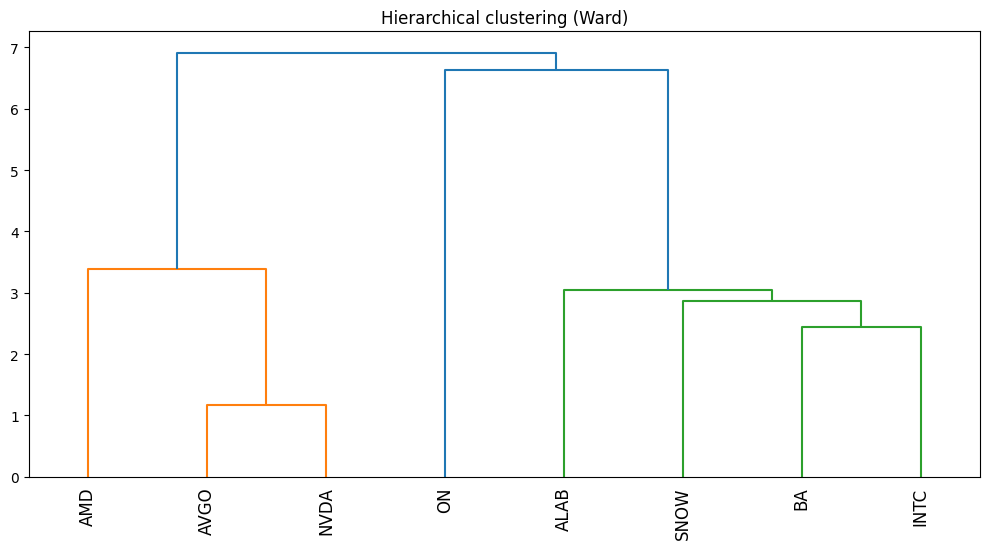

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

def plot_dendrogram_from_betas(B: pd.DataFrame):
    # standardize PCs so no single PC dominates
    Z = StandardScaler().fit_transform(B.values)
    L = linkage(Z, method="ward")  # Euclidean Ward
    plt.figure(figsize=(10, 4 + 0.2*len(B)))
    dendrogram(L, labels=B.index.tolist(), leaf_rotation=90)
    plt.title("Hierarchical clustering (Ward)")
    plt.tight_layout()
    plt.show()

plot_dendrogram_from_betas(B)


In [ ]:
importlib.reload(stock_data_functions)
from stock_data_functions import TickerData

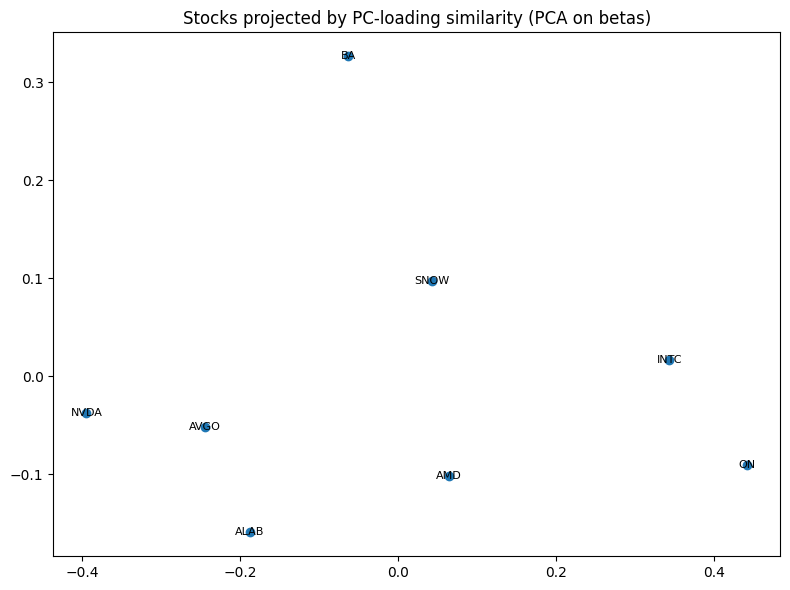

In [ ]:
from sklearn.decomposition import PCA as SKPCA

def scatter_2d_from_betas(B: pd.DataFrame):
    Z = SKPCA(n_components=2).fit_transform(B.values)
    plt.figure(figsize=(8,6))
    plt.scatter(Z[:,0], Z[:,1])
    for (x,y), label in zip(Z, B.index):
        plt.text(x, y, label, ha="center", va="center", fontsize=8)
    plt.title("Stocks projected by PC-loading similarity (PCA on betas)")
    plt.tight_layout(); plt.show()
scatter_2d_from_betas(B)

In [ ]:
import stock_data_functions
import importlib

# After editing stock_data_functions.py and saving changes:
importlib.reload(stock_data_functions)

from stock_data_functions import TickerData, GroupComparison

In [ ]:
stocks = GroupComparison(tickers=coef_train_port.keys(), filing_date_gte='2023-09-25')

In [1]:
import stock_data_functions
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import boxcox

# After editing stock_data_functions.py and saving changes:
import importlib

importlib.reload(stock_data_functions)

from stock_data_functions import TickerData, calc_log_rets

### Doing OLS Regression

In [4]:
AVGO = TickerData('AVGO', '2023-09-25')
AVGO.get_historical_prices()
AVGO.get_ratios()
AVGO.calc_zscore_and_rets()
y_df = AVGO.summary_returns_data
y    = y_df['close']

Call AVGO.calc_zscore_and_rets() to get returns data
Request URL: https://api.polygon.io/v2/aggs/ticker/AVGO/range/1/day/2023-09-25/2025-09-26?limit=5000
Request Headers: {'Authorization': 'Bearer REDACTED', 'Accept-Encoding': 'gzip', 'User-Agent': 'Polygon.io PythonClient/1.15.3'}
Response Headers: {'Date': 'Sun, 28 Sep 2025 18:54:14 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': 'a006e78395605d5bc7e0305bfd608d97', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}


In [5]:
NQ = TickerData('I:NDX', '2023-09-25')
NQ.get_historical_prices()
X_df = NQ.historical_prices.apply(calc_log_rets)
X = X_df['close'].to_frame()
X.rename(columns = {'close':'NQ'}, inplace=True)
df = pd.merge(y, X, left_index=True, right_index=True)

Call I:NDX.calc_zscore_and_rets() to get returns data
Request URL: https://api.polygon.io/v2/aggs/ticker/I:NDX/range/1/day/2023-09-25/2025-09-26?limit=5000
Request Headers: {'Authorization': 'Bearer REDACTED', 'Accept-Encoding': 'gzip', 'User-Agent': 'Polygon.io PythonClient/1.15.3'}
Response Headers: {'Date': 'Sun, 28 Sep 2025 18:54:20 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding', 'X-Polygon-Cluster-Name': 'polygon-ny5', 'X-Request-Id': 'aee72ec47d58dfa425f779d01025f54e', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}


/Users/phillip/Desktop/Moon2/stock_data_functions.py:31: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = df.pct_change().dropna()


In [59]:
model = LinearRegression().fit(X = df['NQ'].values.reshape(-1,1), y= df['close'])
model.score(df['NQ'].values.reshape(-1,1),df['close'])

0.5334761826265462

In [79]:
model.coef_

array([1.79032867])

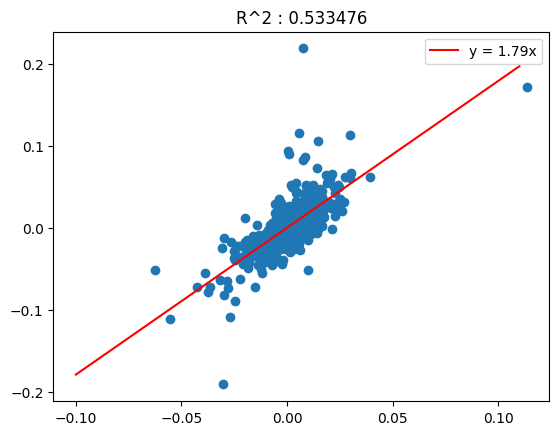

In [104]:
plt.scatter(x=df['NQ'], y=df['close'])

x_ = np.linspace(-0.1, 0.11, 12)
y_ = x_ * model.coef_
plt.plot(x_, y_, color = 'red', label = f'y = {model.coef_[0].round(2)}x')
plt.title(f"R^2 : {model.score(df['NQ'].values.reshape(-1,1), df['close']):2f}")
plt.legend()

In [327]:
def get_beta_hat(target_y : pd.DataFrame,
                 design_matrix : pd.DataFrame):
    """  
    beta_hat = (y - b xT)^T (y - b xT)

    differentiate wrt to beta gives
        beta_hat = (XT X)^-1 X^T y

    Matrix must be (500, 1) this is 2D not 1D
    """
    X        = design_matrix.values
    X        = X.reshape(-1, 1)
    y        = target_y.values
    y        = y.reshape(-1, 1)

    print('shape of', X.shape, y.shape)
    XtX      = X.T @ X
    Xty      = X.T @ y

    beta_hat = np.linalg.inv(XtX) @ Xty 
    return beta_hat, X,y

beta_hat, X,y = get_beta_hat(df['close'], df['NQ'])

shape of (500, 1) (500, 1)


In [328]:
def compute_resid(beta_hat, y, X):

    y_hat               = beta_hat * X 
    resids              = y - y_hat
    squared_error       = (y - y_hat) ** 2
    sum_squared_err     = sum(squared_error)

    mse                 = np.mean(squared_error)

    return y_hat, squared_error, sum_squared_err, mse, resids

def resid_analysis(y_hat, target_y, squared_error, mse):
    """
    Plot 1 : errors vs predicted values 
    """ 

    

In [329]:
y_hat, squared_error, sum_squared_err, mse, resids = compute_resid(beta_hat, y=y, X=X)
mse

np.float64(0.0004803733184960891)

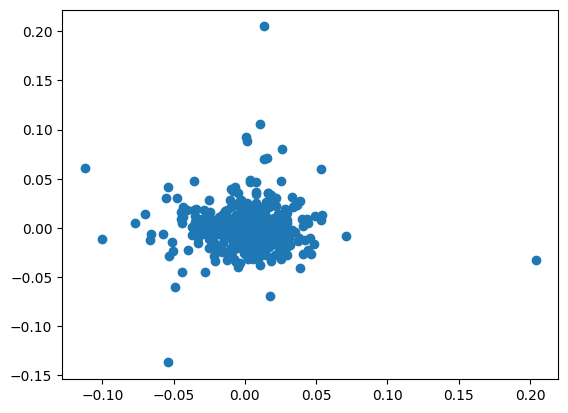

In [156]:
plt.scatter(y = resids, x = y_hat)

<Axes: ylabel='Count'>

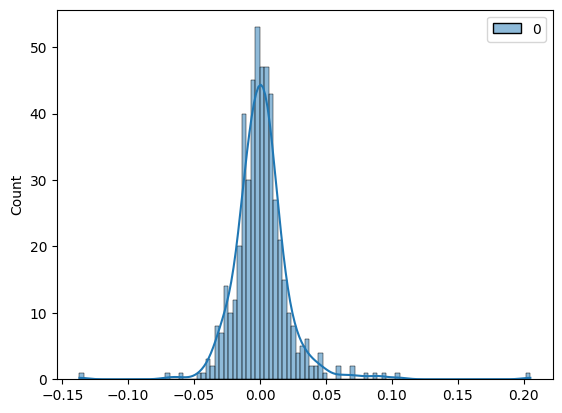

In [160]:
sns.histplot(resids, bins=100, kde=True)

In [180]:
import scipy.stats as stats
from fredapi import Fred
fred_api = Fred('e48d0413b1cd0a3b30b58d42225373de')

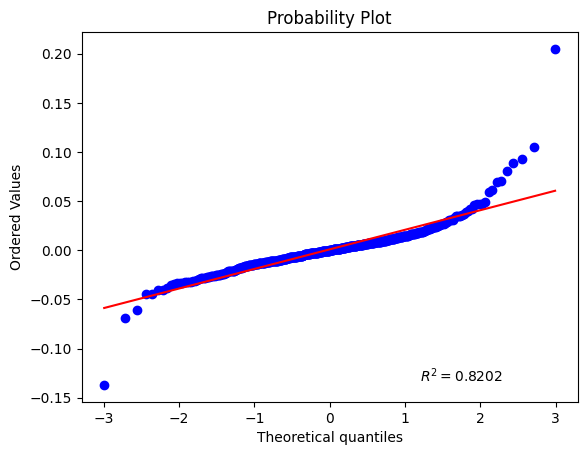

In [175]:
qq_plot = stats.probplot(x = resids.flatten(), dist = 'norm', plot = plt, rvalue=True)

In [255]:
VIX = fred_api.get_series('VIXCLS', observation_start='2023-09-25', observation_end='2025-09-25').to_frame('VIX')
VIX_3m = fred_api.get_series('VXVCLS', observation_start='2023-09-25', observation_end='2025-09-25').to_frame('VIX 3m')
VXN = fred_api.get_series('VXNCLS', observation_start='2023-09-25', observation_end='2025-09-25').to_frame('VXN')


In [258]:
VIXs = pd.merge(VIX, VIX_3m, left_index=True, right_index=True, how='outer')
VIXs = pd.merge(VXN, VIXs, left_index=True, right_index=True, how='outer')
VIXs_missing_mask = VIXs.index[VIXs['VIX'].isna() | VIXs['VIX 3m'].isna() | VIXs['VXN'].isna()]
display(VIXs.loc[VIXs_missing_mask])
VIXs.dropna(inplace=True)

,VXN,VIX,VIX 3m
2023-11-23,NaN,12.80,NaN
2023-12-25,NaN,NaN,NaN
2024-01-01,NaN,NaN,NaN
2024-01-15,NaN,13.25,NaN
2024-02-19,NaN,14.71,NaN
2024-03-29,NaN,NaN,NaN
2024-05-27,NaN,12.36,NaN
2024-06-19,NaN,12.48,NaN
2024-07-04,NaN,12.26,NaN
2024-09-02,NaN,15.55,NaN


In [259]:
VIXs.corr()

,VXN,VIX,VIX 3m
VXN,1.000000,0.960138,0.939470
VIX,0.960138,1.000000,0.974838
VIX 3m,0.939470,0.974838,1.000000


In [253]:
display(pd.DataFrame(np.cov(VIXs['VIX'], VIXs['VIX 3m']), index=['VIX', 'VIX 3m'], columns=['VIX', 'VIX 3m']))
corr_vix_vix3m = np.cov(VIXs['VIX'], VIXs['VIX 3m'])[0,1] / (VIXs['VIX'].std() * VIX_3m['VIX 3m'].std())
print('VIX-VIX3m corr', corr_vix_vix3m.round(2))

,VIX,VIX 3m
VIX,22.933207,16.995883
VIX 3m,16.995883,13.254336


VIX-VIX3m corr 0.97


In [269]:
from statsmodels.tsa.stattools import adfuller

print('p-value', adfuller(VIXs['VXN'])[1].round(4), '%')

p-value 0.0012 %


In [419]:
all_df = pd.merge(VIXs, df, how = 'inner', left_index=True, right_index=True)
with_rsi = all_df.dropna()

In [425]:
y = with_rsi['close'].values.reshape(-1, 1)
X = with_rsi[['rsi_14', 'NQ']]

XtX = X.T @ X 
Xty = X.T @ y
beta_hat = np.linalg.inv(XtX) @ Xty

y_fitted = X @ beta_hat.to_numpy()
resids = all_df['close'].to_frame('AVGO') - y_fitted.rename(columns={0:'AVGO'})
beta_hat

,0
0,0.000040
1,1.784544


In [ ]:
lst_squares_calc = np.linalg.lstsq(X, y, rcond=-1)
beta_hat_optimised  = lst_squares_calc[0]
residuals_optimised = lst_squares_calc[1]

y_fitted_optimised = X @ beta_hat_optimised
sum_squared_err_optimised = (y - y_fitted_optimised)**2
sum_squared_err_optimised.sum() / 499


In [407]:
import ta

In [471]:
# RSI
avgo_rsi = ta.momentum.RSIIndicator(close=df['close'], window=1).rsi()
df['rsi'] = avgo_rsi

df2 = df.copy()
df2['rsi'] = df2['rsi'].shift(-1)
df2.drop('rsi_14', inplace=True,axis=1)
df2.dropna(inplace=True)

In [4]:
from stock_data_functions import get_top_N_US_stocks, TickerData

In [396]:
# Get all stocks of top X market cap
top50_stocks = get_top_N_US_stocks(50)
top200_stocks = get_top_N_US_stocks(200)


/Users/phillip/Desktop/Moon2/stock_data_functions.py:44: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)
/Users/phillip/Desktop/Moon2/stock_data_functions.py:44: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text)


In [6]:
tickers = list(set(top100_stocks).difference(set(collected_tickers)))

In [7]:
tickers

['GOOG', 'COF', 'TSLA', 'LMT', 'XOM', 'GEV', 'PFE', 'NVDA', 'INTC']

In [ ]:
# Loop to get this data
failled = []

for tkr in top200_stocks[100:]:
    print(f"{tkr} — starting")
    try:
        x = TickerData(tkr, filing_date_gte="2023-09-26")

        try:
            stock_data_functions.fetch_in_six_month_chunks(x, tkr, months_per_chunk=3, cooldown_sec=60)
            print(f"{tkr} — success on first try")
        except:
            try:
                stock_data_functions.fetch_in_six_month_chunks(x, tkr, months_per_chunk=1, cooldown_sec=60)
                print(f"{tkr} — success on second try")
            except:
                try:
                    stock_data_functions.fetch_in_six_month_chunks(x, tkr, months_per_chunk=0.5, cooldown_sec=60)
                    print(f"{tkr} — success on third try")
                except:
                    failled.append(tkr)
                    print(f"{tkr} — all attempts failed")

    except Exception as e:
        failled.append(tkr)
        print(f"{tkr} — setup failed: {e}")

print("\nFailed tickers:", failled)



In [29]:
from glob import glob
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import stock_data_functions
import numpy as np
import datetime as dt
from stock_data_functions import calc_log_rets, TickerData

In [ ]:
def get_all_returns_data():

    pattern             = os.path.join('Datasets', "*_5minute_2023-09_minute_level_data.csv")
    csv_files           = glob(pattern)
    collected_tickers   = [os.path.basename(f).split("_")[0] for f in csv_files]
    dfs                 = []
    try_again           = []

    # See what we have
    for i in collected_tickers:
        try:

            df              = stock_data_functions \
                            .get_minute_level_data(i, n =5, period='minute', start_date='2023-09-26')
            x               = df[['vwap']].rename(columns={'vwap':i})
            dfs.append(x)
        except Exception as e:
            print(e, i)
            try_again.append(i)
    
    return collected_tickers, try_again

In [30]:
df = pd.concat(dfs, axis=1)

t = df.index.time  # ndarray of datetime.time

df['session'] = np.select(
        [
            (t >= dt.time(4, 0))  & (t < dt.time(9, 30)),   # Pre-Market
            (t >= dt.time(9, 30)) & (t < dt.time(16, 0)),   # Regular
            (t >= dt.time(16, 0)) & (t < dt.time(20, 0)),   # Post-Market
        ],
        ['Pre-Market', 'Regular', 'Post-Market'],
        default='closed'
    )
regular_df = df[df['session'] == 'Regular']
regular_df = regular_df.iloc[:, :-1].apply(calc_log_rets)

In [50]:
sector_map = {
    'Biotech'             : ['GILD', 'ABBV', 'BSX', 'AMGN', 'ISRG', 'MDT', 'ABT', 'TMO', 'LLY', 'DHR', 'SYK',
                             'DHR'],
    'Consumer'            : ['HD', 'LOW', 'PG', 'PEP', 'AMZN', 'MRK', 'JNJ', 'DASH', 'KO', 'APP', 'PM', 'BKNG',
                             'TJX','COST', 'MCD'],
    'Healthcare'          : ['AMGN','MRK', 'UNH'],
    'Business Software'   : ['CSCO', 'NOW', 'ORCL', 'PANW', 'CRM', 'AMZN', 'CRWD', 'ADP', 'ADBE', 'IBM', 'MSFT'],
    'Telecoms'            : ['T', 'VZ', 'APH', 'TMUS', 'INTU'],
    'Mega-Cap Tech'       : ['AAPL', 'UBER', 'META', 'CSCO', 'ORCL', 'NFLX', 'AMZN', 'AVGO', 'PLTR', 'DASH','APP',
                             'GOOGL', 'IBM', 'MSFT', 'ANET'],
    'Financials'          : ['AXP', 'V', 'MA', 'BAC', 'SPGI', 'BLK', 'SCHW', 'BX', 'PGR', 'C', 'CB', 'MS', 'ACN'
                             ,'WFC', 'KKR', 'GS', 'JPM'] ,
    'Industrials'         : ['LIN', 'HON', 'PG', 'GE', 'BA', 'CAT', 'RTX'],
    'Semi'                : ['AMAT', 'TXN', 'QCOM', 'AMD', 'AVGO', 'MU', 'KLAC', 'ADI', 'ANET', 'LRCX'],
    'Power'               : ['ETN', 'HON', 'GE', 'NEE', 'DE'],
    'Oil & Gas'           : ['CVX', 'COP'],
    'Other'               : ['CMCSA', 'DIS', 'GE', 'BA', 'PGR', 'WMT', 'UNP','WELL', 'BKNG', 'RTX']
}

# Check if all the collected tickers are in the list
present         = set().union(*(set(v) for v in sector_map.values()))
missing         = set(collected_tickers).difference(present)
missing

# Map into df space
sector_dfs = {}
for i,v in sector_map.items():
    sector_dfs[i] = regular_df[v]


In [93]:
start_window = '2025-05-01'
end_window   = '2025-9-25'


def pca_analysis(tag : str, dfs, start_date=start_window, end_date = end_window):
    """
    Selects from the big dictionary of returns
    """
    if tag == False:
        df_i = dfs
    else:
        df_i              = dfs[tag] 
    
    df_i = df_i.loc[start_window : end_window].copy()

    print(df_i.index[0], df_i.index[-1])
    # Standardise
    standardised_rets = pd.DataFrame(StandardScaler().fit_transform(df_i),
                                     columns = df_i.columns,
                                     index   = df_i.index)
    pca      = PCA().fit(standardised_rets)
    
    loadings                = pd.DataFrame(pca.components_.T,
                                           index   = standardised_rets.columns,
                                           columns = [f'PC{i+1}' for i in range(len(standardised_rets.columns))])
    explained_var_by_PC     = pd.DataFrame(pca.explained_variance_ratio_,
                                           index = loadings.columns,
                                           columns = ['PC'])
    
    return loadings, explained_var_by_PC

In [176]:
def top_stocks_per_pc(loadings, n = 20, top=10):
    """  
    Given a dataframe of principle components and loadings
    """
    
    group       = {}
    for i in range(n):
        loadings_pc_i               = loadings.sort_values(by=f'PC{i+1}', ascending=False)
        group[f'PC{i+1}']           = loadings_pc_i.index[:top] 
        group[f'PC{i+1}']           = loadings_pc_i.iloc[:top, i]

    
    df = pd.concat(group, axis=0).to_frame('Value')
    df.reset_index(inplace=True)
    df.rename(columns={'level_0':'PC', 'level_1':'Ticker'}, inplace=True)
    df.set_index(['PC', 'Ticker'], inplace=True)
    
    return df    



In [404]:
def sector_centroids(loadings, sector_maps):
    rows = []
    for sector, names in sector_maps.items():
        names = [n for n in names if n in loadings.index]
        if not names: 
            continue
        rows.append(pd.DataFrame(loadings.loc[names].mean().rename(sector)))
    return pd.concat(rows, axis=1).T.sort_index()


In [403]:
def top_abs_per_pc(loadings, n=10):
    out = []
    for pc in loadings.columns:
        s = loadings[pc].sort_values(key=lambda x: x.abs(), ascending=False).head(n)
        out.append(pd.DataFrame({"pc": pc, "ticker": s.index, "loading": s.values}))
    return pd.concat(out, ignore_index=True)


### Price Discovery

Seeing how much information is in the first 15 minutes of the US open

In [ ]:
Ticker = TickerData('MU', filing_date_gte='2023-09-01')
Ticker.get_historical_prices(period = 'minute', n=5, start_date='2023-09-26')
Ticker.get_ratios()
df = Ticker.minute_level_prices.copy()
df_open = df.between_time('09:30', '10:00')


Trying to get minute level data
Data Found


In [963]:
from pca_functions import get_all_returns_data, filter_session

In [ ]:
dfs = get_all_returns_data()
dfs_rets = filter_session(dfs[0], session = False)
df_first_15min = dfs_rets.between_time('9:30', '9:45')
df_remainder = dfs_rets.between_time('9:45', '16:00')

In [981]:
ticker = 'MU'
first_15min = df_first_15min[ticker].copy()
df_remainder = df_remainder[ticker].copy()

In [982]:
first_15min

2023-09-29 09:30:00-04:00    0.007664
2023-09-29 09:35:00-04:00    0.005796
2023-09-29 09:40:00-04:00   -0.005362
2023-09-29 09:45:00-04:00    0.010560
2023-09-30 09:30:00-04:00    0.000000
                               ...   
2025-09-25 09:45:00-04:00    0.003746
2025-09-26 09:30:00-04:00   -0.002658
2025-09-26 09:35:00-04:00    0.002227
2025-09-26 09:40:00-04:00   -0.005235
2025-09-26 09:45:00-04:00   -0.002654
Name: MU, Length: 2916, dtype: float64

In [ ]:
returns_type = 'intraday'
Stock.summary_returns_data.loc[]

,open,z open,bucket open,high,z high,bucket high,low,z low,bucket low,close,...,bucket close,vwap,z vwap,bucket vwap,intraday,z intraday,bucket intraday,overnight,z overnight,bucket overnight
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-04,-0.011624,-0.591976,Normal,-0.005667,-0.325577,Normal,0.010481,0.460674,Normal,0.027431,...,Moderate Positive,0.018776,0.891668,Normal,0.017684,0.965854,Normal,0.009747,0.665670,Normal
2023-10-05,0.015341,0.692281,Normal,-0.000382,-0.059165,Normal,0.004032,0.152431,Normal,-0.001192,...,Normal,0.000444,-0.019868,Normal,0.001151,0.082756,Normal,-0.002343,-0.282411,Normal
2023-10-06,-0.006932,-0.368523,Normal,0.038251,1.888131,Moderate Positive,0.003197,0.112502,Normal,0.038357,...,Moderate Positive,0.031675,1.533027,Moderate Positive,0.046440,2.501864,Large Positive,-0.008083,-0.732564,Normal
2023-10-09,0.034896,1.623619,Moderate Positive,0.015559,0.744360,Normal,0.035841,1.672767,Moderate Positive,0.013801,...,Normal,0.016160,0.761571,Normal,0.025345,1.375071,Moderate Positive,-0.011544,-1.003982,Moderate Negative
2023-10-10,0.029098,1.347473,Moderate Positive,0.018799,0.907667,Normal,0.024155,1.114207,Moderate Positive,0.009697,...,Normal,0.018580,0.881925,Normal,0.005944,0.338763,Normal,0.003753,0.195602,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-24,-0.011563,-0.589085,Normal,-0.013892,-0.740168,Normal,-0.022730,-1.126731,Moderate Negative,-0.025829,...,Moderate Negative,-0.024190,-1.244799,Moderate Negative,-0.026948,-1.418105,Moderate Negative,0.001119,-0.010975,Normal
2025-09-25,-0.039464,-1.917905,Moderate Negative,-0.032369,-1.671496,Moderate Negative,-0.016350,-0.821776,Normal,-0.016667,...,Normal,-0.016947,-0.884620,Normal,-0.004150,-0.200391,Normal,-0.012516,-1.080224,Moderate Negative
2025-09-26,-0.007403,-0.390932,Normal,-0.011160,-0.602430,Normal,-0.008723,-0.457229,Normal,-0.002710,...,Normal,-0.007490,-0.414398,Normal,0.000543,0.050286,Normal,-0.003253,-0.353766,Normal


In [ ]:
sector_tickers = {'Semiconductor' : ['NVDA', 'AVGO',
 'AMD',
 'MU',
 'QCOM',
 'TXN',
 'INTC',
 'ADI',
 'MRVL',
 'NXPI',
 'MPWR',
 'MCHP',
 'ALAB',
 'CRDO',
 'STM',
 'ASX',
 'ON',
 'GFS',
 'UMC',
 'SMTC',
 'LRCX',
 'KLAC',
 'TSM',
 'TER',
 'ENTG',
 'ARM',
 'RMBS',
 'MTSI']}

['NVDA',
 'AVGO',
 'AMD',
 'MU',
 'QCOM',
 'TXN',
 'INTC',
 'ADI',
 'MRVL',
 'NXPI',
 'MPWR',
 'MCHP',
 'ALAB',
 'CRDO',
 'STM',
 'ASX',
 'ON',
 'GFS',
 'UMC',
 'SMTC',
 'LRCX',
 'KLAC',
 'TSM',
 'TER',
 'ENTG',
 'ARM',
 'RMBS',
 'MTSI']